In [1]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt

from fredapi import Fred
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller

%matplotlib inline

import warnings

warnings.filterwarnings("ignore")

In [91]:
f_series = Fred(api_key = '179c01007df2797c265503e905c9addd')

#Get the time series data for unemployment, gdp growth rate, core pce, and the 10y2y yield spread

unem_series = pd.DataFrame(f_series.get_series('UNRATE', observation_start = '2000-01-01', frequency = 'q'))

gdp_series = pd.DataFrame(f_series.get_series('GDP', observation_start = '1999-12-01', frequency = 'q'))

gdp_series = (np.log(gdp_series / gdp_series.shift(1)) * 100).dropna()

c_pce_series = pd.DataFrame(f_series.get_series('DPCCRC1M027SBEA', observation_start = '1999-12-01', frequency = 'q'))
                            
c_pce_series = (np.log(c_pce_series / c_pce_series.shift(1)) * 100).dropna()                            

msupply_series = pd.DataFrame(f_series.get_series('M2SL', observation_start = '2000-01-01', frequency = 'q'))

In [92]:
#Combine all time series into a single dataframe and rename columns as per the variable names

time_series = pd.concat([unem_series, gdp_series, c_pce_series, msupply_series], axis = 1)

columns = ['Unemployment Rate', 'GDP Growth Rate', 'Core PCE', 'Money Supply']

time_series.columns = columns

time_series = time_series.dropna()

In [93]:
#Before we run the VAR model, we want to ensure the time series data are stationary

time_series_df1 = pd.DataFrame()

time_series_df2 = pd.DataFrame()

for series in time_series.columns:
    
    #For each time series in the original DataFrame, we take the first and second differences and store 
    #the results in different DataFrames
    
    time_series_df1[series] = (time_series[series] - time_series[series].shift(1)).dropna()
    
    time_series_df2[series] = (time_series[series] - time_series[series].shift(2)).dropna()

In [94]:
#Create a DataFrame that stores the p_values from running the ADF test for stationarity on individual time series

adf_df = pd.DataFrame(index = time_series.columns, columns = ['variable_pvalues', 'df1_pvalue', 'df2_pvalue', 
                                                             'Integration Order'])

for series in time_series.columns:
    
    #We run a regression with a constant for the non-differenced time series to control for the trend
    
    adf_df.loc[series, 'variable_pvalues'] = adfuller(time_series[series], autolag = 'aic', regression = 'c')[1]
    
    adf_df.loc[series, 'df1_pvalue'] = adfuller(time_series_df1[series], autolag = 'aic', regression = 'n')[1]
    
    adf_df.loc[series, 'df2_pvalue'] = adfuller(time_series_df2[series], autolag = 'aic', regression = 'n')[1]
    
#Run another for loop that indicates the number of lags to be considered for each time series to be stationary
    
for series in adf_df.index:
    
        if adf_df.loc[series, 'variable_pvalues'] < 0.05:
            
            adf_df.loc[series, 'Integration Order'] = 0
            
        elif adf_df.loc[series, 'df1_pvalue'] < 0.05:
            
            adf_df.loc[series, 'Integration Order'] = 1
            
        elif adf_df.loc[series, 'df2_pvalue'] < 0.05:
            
            adf_df.loc[series, 'Integration Order'] = 2
            
adf_df

#From the table we can see that both for Unemployment and the 10y2y Spread we have to use the first difference 
#for the data to be stationary. For the other variables no differencing is required as the null hypothesis of 
#non-stationarity is rejected with a p-value significantly below 0.05

,variable_pvalues,df1_pvalue,df2_pvalue,Integration Order
Unemployment Rate,0.051786,0.0,0.000021,1
GDP Growth Rate,0.0,0.0,0.000002,0
Core PCE,0.0,0.0,0.0,0
Money Supply,1.0,0.020408,0.013274,1


In [95]:
#Creating a new time series DataFrame that stores the time series in line with the integration order as calculated
#above

time_series_formatted = pd.DataFrame()

for series in time_series.columns:
    
    if adf_df.loc[series, 'Integration Order'] == 0:
        
        time_series_formatted[series] = time_series[series]
        
    elif adf_df.loc[series, 'Integration Order'] == 1:
        
        time_series_formatted[str(str(series)+'_df1')] = np.log(time_series[series] / time_series[series].shift(1)) * 100
    
    elif adf_df.loc[series, 'Integration Order'] == 2:
        
        df1 = np.log(time_series_df2[series] / time_series_df2[series].shift(1))
        
        time_series_formatted[str(str(series)+'_df2')] = np.log(df1 / df1.shift(1)) * 100
        
time_series_formatted = time_series_formatted.dropna()

In [96]:
model = VAR(time_series_formatted)

results = model.fit(1, ic = 'aic')

results.summary()

#Given the results below, we want to focus on the overall model rather than the individual time series regressions
#in deciding the predictive power of the model - as such, the results output below is not of significant concern
#as it provides the parameters for the individual time series

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Sun, 22, Sep, 2024
Time:                     14:39:34
--------------------------------------------------------------------
No. of Equations:         4.00000    BIC:                    2.83746
Nobs:                     96.0000    HQIC:                   2.51917
Log likelihood:          -635.427    FPE:                    10.0101
AIC:                      2.30322    Det(Omega_mle):         8.17033
--------------------------------------------------------------------
Results for equation Unemployment Rate_df1
                              coefficient       std. error           t-stat            prob
-------------------------------------------------------------------------------------------
const                           10.630552         2.928409            3.630           0.000
L1.Unemployment Rate_df1        -0.553011         0.223641           -2.473           0.013


In [97]:
from statsmodels.tsa.stattools import grangercausalitytests

In [100]:
#Following from above, we want to test the strength of the regression on a model level rather than an indivudal 
#level and as such we run a Granger Causality test to see whether GDP Growth Rate can be causally explained by
#the other variables in our model

granger_test = results.test_causality('GDP Growth Rate', ['Unemployment Rate_df1', 'Core PCE', 'Money Supply_df1'], 
                                 kind = 'f')

print(granger_test.summary())

#Given the p-value is less than 0.05, we can reject the null hypothesis of no causality at the 5% significance level

Granger causality F-test. H_0: ['Unemployment Rate_df1', 'Core PCE', 'Money Supply_df1'] do not Granger-cause GDP Growth Rate. Conclusion: reject H_0 at 5% significance level.
Test statistic Critical value p-value    df   
----------------------------------------------
         7.978          2.629   0.000 (3, 364)
----------------------------------------------


<Figure size 2500x1000 with 0 Axes>

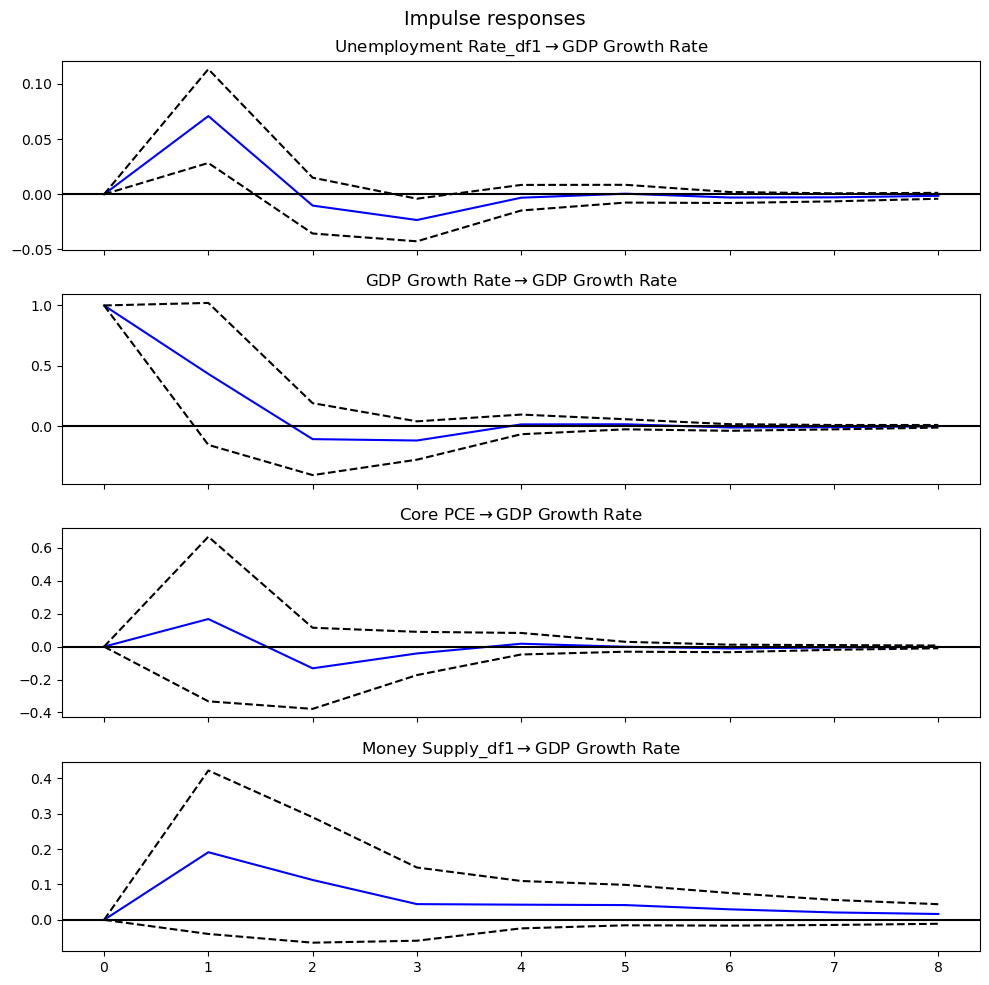

In [102]:
#Given that the model has predictive power from the above test, we can also plot out the impulse response functions
#for the variables to see what impact they have on GDP Growth Rates as that is our primary forecast variable

fig = plt.figure(figsize = (25, 10))

irf = results.irf(8)

irf.plot(response ='GDP Growth Rate')

plt.tight_layout()

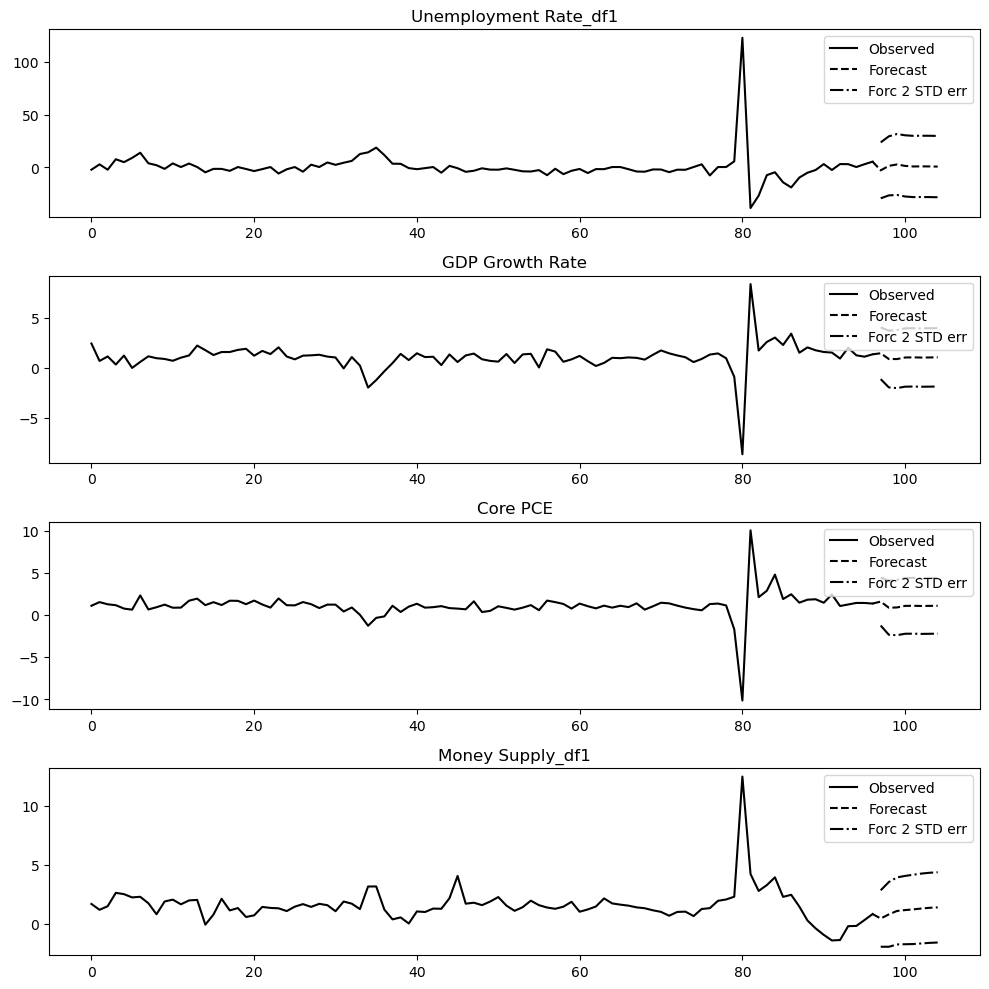

In [105]:
#Lastly we can plot out the forecasted values from the VAR model using 8 periods for forecasting out 2 years
#as the original data is quarterly

results.plot_forecast(8)

plt.tight_layout()

plt.show()